## POS tagging using modified Viterbi

### Data Preparation

In [69]:
#Importing libraries
import nltk, re, pprint
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [70]:
import nltk
nltk.download('treebank')
nltk.download('punkt')
nltk.download('universal_tagset')
nltk_data=list(nltk.corpus.treebank.tagged_sents(tagset='universal'))



[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\WEL\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\WEL\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\WEL\AppData\Roaming\nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [71]:
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [72]:
#Dividing it into train and test set split
import random
from sklearn.model_selection import train_test_split
random.seed(1234)
train_set, test_set = train_test_split(nltk_data,test_size=0.05)

print(len(train_set))
print(len(test_set))
print(train_set[:40])

3718
196
[[('``', '.'), ('The', 'DET'), ('morbidity', 'NOUN'), ('rate', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('striking', 'ADJ'), ('finding', 'NOUN'), ('among', 'ADP'), ('those', 'DET'), ('of', 'ADP'), ('us', 'PRON'), ('who', 'PRON'), ('*T*-5', 'X'), ('study', 'VERB'), ('asbestos-related', 'ADJ'), ('diseases', 'NOUN'), (',', '.'), ("''", '.'), ('said', 'VERB'), ('*T*-1', 'X'), ('Dr.', 'NOUN'), ('Talcott', 'NOUN'), ('.', '.')], [('The', 'DET'), ('idea', 'NOUN'), (',', '.'), ('of', 'ADP'), ('course', 'NOUN'), (':', '.'), ('*', 'X'), ('to', 'PRT'), ('prove', 'VERB'), ('to', 'PRT'), ('125', 'NUM'), ('corporate', 'ADJ'), ('decision', 'NOUN'), ('makers', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('buckle', 'NOUN'), ('on', 'ADP'), ('the', 'DET'), ('Rust', 'NOUN'), ('Belt', 'NOUN'), ('is', 'VERB'), ("n't", 'ADV'), ('so', 'ADV'), ('rusty', 'ADJ'), ('after', 'ADP'), ('all', 'DET'), (',', '.'), ('that', 'ADP'), ('it', 'PRON'), ("'s", 'VERB'), ('a', 'DET'), ('good', 'ADJ'), ('place', 'NOUN'), ('

In [73]:

# Getting list of tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95526

In [74]:

# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:10]


['``',
 'The',
 'morbidity',
 'rate',
 'is',
 'a',
 'striking',
 'finding',
 'among',
 'those']

# vocabulary

In [75]:

V = set(tokens)
print(len(V))

12084


In [76]:

# number of tags
T = set([pair[1] for pair in train_tagged_words])
print(len(T))
print(T)

12
{'X', 'PRT', 'NOUN', 'NUM', 'ADV', 'CONJ', '.', 'VERB', 'ADJ', 'ADP', 'DET', 'PRON'}


### Emission Probabilities

In [77]:
# computing P(w/t) and storing in T x V matrix
import numpy as np
t = len(T)
v = len(V)
w_given_t = np.zeros((t, v))

In [78]:

# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [79]:

# compute tag given tag: tag2(t2) given tag1 (t1): Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

# Tags Matrix

In [80]:
tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

tags_matrix

array([[7.48006403e-02, 1.84689000e-01, 6.20414689e-02, 2.87081348e-03,
        2.51993611e-02, 1.03668263e-02, 1.65390745e-01, 2.03189790e-01,
        1.65869221e-02, 1.45454541e-01, 5.55023924e-02, 5.39074950e-02],
       [1.34338140e-02, 1.63826998e-03, 2.49672353e-01, 5.60288318e-02,
        9.50196572e-03, 2.29357788e-03, 4.25950214e-02, 4.02031451e-01,
        8.28964636e-02, 2.06422023e-02, 1.01245083e-01, 1.80209707e-02],
       [2.94021089e-02, 4.41031642e-02, 2.64473051e-01, 9.41159297e-03,
        1.70357134e-02, 4.23156880e-02, 2.39813223e-01, 1.47010535e-01,
        1.22569585e-02, 1.76339686e-01, 1.32783717e-02, 4.55988012e-03],
       [2.11447209e-01, 2.72835121e-02, 3.52016598e-01, 1.86239615e-01,
        2.96559907e-03, 1.42348753e-02, 1.15361802e-01, 1.80901550e-02,
        3.29181477e-02, 3.46975103e-02, 3.26215895e-03, 1.48279953e-03],
       [2.16018613e-02, 1.49551341e-02, 3.15719508e-02, 3.15719508e-02,
        7.80990347e-02, 6.64672628e-03, 1.38251916e-01, 3.47

# Creating a DataFrame for Tag Matrix

In [81]:
# convert the matrix to a df for better readability
import pandas as pd
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))
tags_df

,X,PRT,NOUN,NUM,ADV,CONJ,.,VERB,ADJ,ADP,DET,PRON
X,0.074801,0.184689,0.062041,0.002871,0.025199,0.010367,0.165391,0.203190,0.016587,0.145455,0.055502,0.053907
PRT,0.013434,0.001638,0.249672,0.056029,0.009502,0.002294,0.042595,0.402031,0.082896,0.020642,0.101245,0.018021
NOUN,0.029402,0.044103,0.264473,0.009412,0.017036,0.042316,0.239813,0.147011,0.012257,0.176340,0.013278,0.004560
NUM,0.211447,0.027284,0.352017,0.186240,0.002966,0.014235,0.115362,0.018090,0.032918,0.034698,0.003262,0.001483
ADV,0.021602,0.014955,0.031572,0.031572,0.078099,0.006647,0.138252,0.347624,0.129279,0.117315,0.067464,0.015620
CONJ,0.008403,0.004669,0.347339,0.041550,0.054622,0.000467,0.036881,0.156863,0.119048,0.051821,0.119514,0.058824
.,0.026217,0.002424,0.222661,0.080894,0.052792,0.058000,0.094541,0.088975,0.043634,0.090501,0.174268,0.065003
VERB,0.217980,0.030718,0.110040,0.023330,0.082199,0.005444,0.034917,0.168987,0.065557,0.092231,0.133681,0.034917
ADJ,0.020452,0.010556,0.700148,0.020782,0.004618,0.016493,0.064325,0.012040,0.065974,0.078839,0.005113,0.000660
ADP,0.034505,0.001389,0.322188,0.062493,0.013353,0.000855,0.039846,0.008546,0.107040,0.016985,0.324324,0.068476


In [82]:

tags_df.loc['.', :]

X       0.026217
PRT     0.002424
NOUN    0.222661
NUM     0.080894
ADV     0.052792
CONJ    0.058000
.       0.094541
VERB    0.088975
ADJ     0.043634
ADP     0.090501
DET     0.174268
PRON    0.065003
Name: ., dtype: float32

# Heatmap of tags matrix

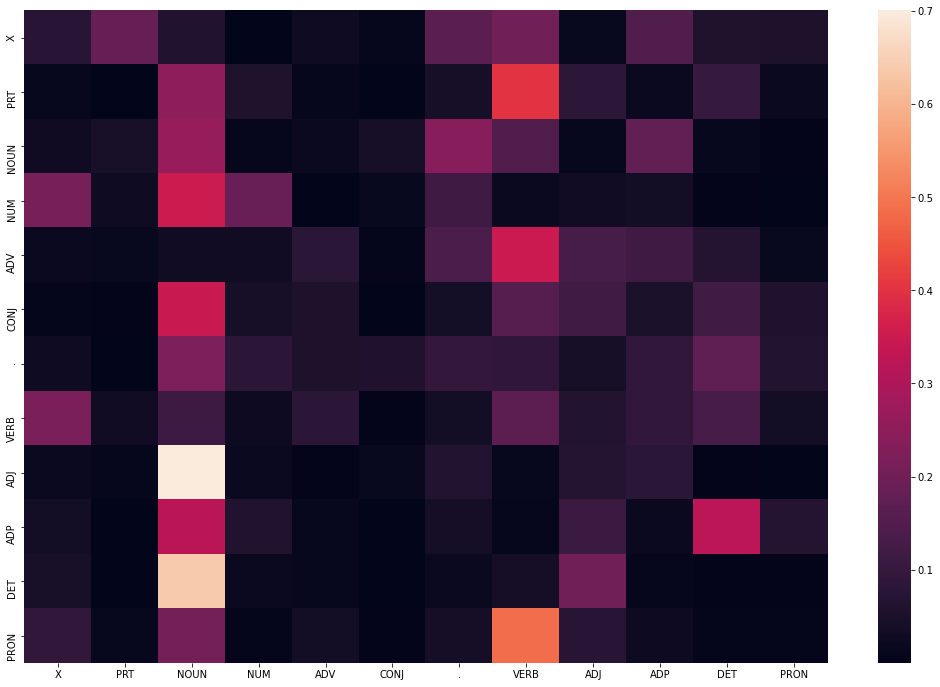

In [83]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()

# Frequent tags

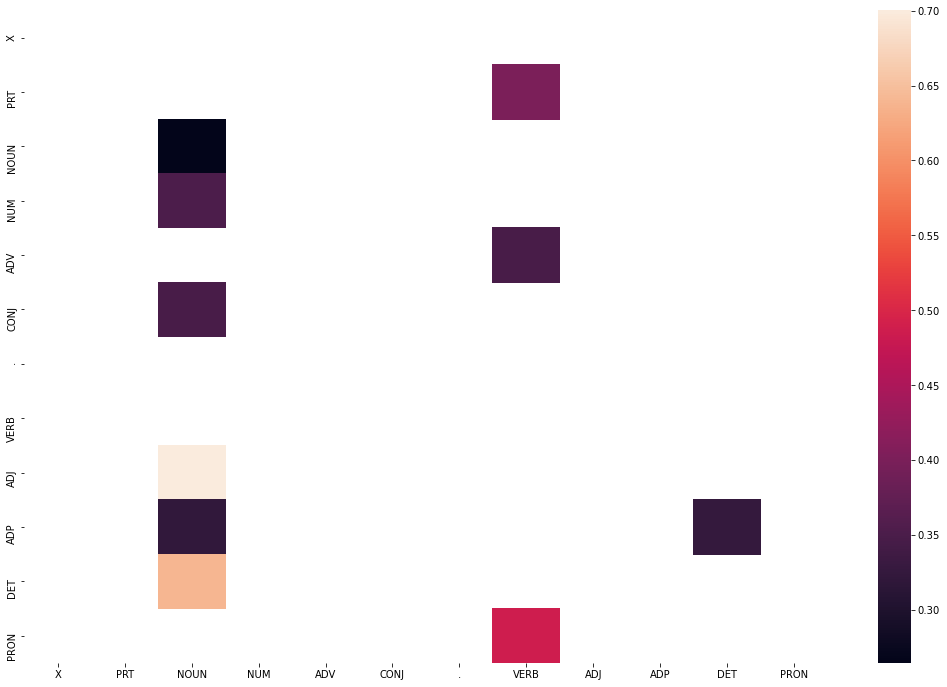

In [84]:
# filter the df to get P(t2, t1) > 0.25
tags_frequent = tags_df[tags_df>0.25]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

# Viterbi Algorithm

In [85]:
len(train_tagged_words)

95526

In [86]:
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

# Evaluating on Test Set

In [87]:

# Running on entire test dataset would take more than 4hrs. 
# Let's test our Viterbi algorithm on a few sample sentences of test dataset

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('Why', 'ADV'),
  ('are', 'VERB'),
  ('we', 'PRON'),
  ('blacks', 'NOUN'),
  ('continually', 'ADV'),
  ('defined', 'VERB'),
  ('*-1', 'X'),
  ('by', 'ADP'),
  ('our', 'PRON'),
  ('minority', 'NOUN'),
  ('and', 'CONJ'),
  ('the', 'DET'),
  ('lowest', 'ADJ'),
  ('common', 'ADJ'),
  ('denominator', 'NOUN'),
  ('.', '.')],
 [('He', 'PRON'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('the', 'DET'),
  ('ban', 'NOUN'),
  ('wo', 'VERB'),
  ("n't", 'ADV'),
  ('stop', 'VERB'),
  ('privately', 'ADV'),
  ('funded', 'VERB'),
  ('tissue-transplant', 'ADJ'),
  ('research', 'NOUN'),
  ('or', 'CONJ'),
  ('federally', 'ADV'),
  ('funded', 'VERB'),
  ('fetal-tissue', 'ADJ'),
  ('research', 'NOUN'),
  ('that', 'DET'),
  ('*T*-111', 'X'),
  ('does', 'VERB'),
  ("n't", 'ADV'),
  ('involve', 'VERB'),
  ('transplants', 'NOUN'),
  ('.', '.')],
 [('Mr.', 'NOUN'),
  ('Coleman', 'NOUN'),
  ('said', 'VERB'),
  ('this', 'DET'),
  ('week', 'NOUN'),
  ('that', 'ADP'),
  ('he', 'PRON'),
  ('would', 'VERB'),
  ('devote', '

# Tagging the test sentences

In [88]:

import time
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start


In [89]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  76.18085312843323
[('Why', 'ADV'), ('are', 'VERB'), ('we', 'PRON'), ('blacks', 'NOUN'), ('continually', 'ADV'), ('defined', 'X'), ('*-1', 'X'), ('by', 'ADP'), ('our', 'PRON'), ('minority', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('lowest', 'ADJ'), ('common', 'ADJ'), ('denominator', 'X'), ('.', '.'), ('He', 'PRON'), ('said', 'VERB'), ('0', 'X'), ('the', 'DET'), ('ban', 'NOUN'), ('wo', 'VERB'), ("n't", 'ADV'), ('stop', 'VERB'), ('privately', 'ADV'), ('funded', 'VERB'), ('tissue-transplant', 'X'), ('research', 'NOUN'), ('or', 'CONJ'), ('federally', 'X'), ('funded', 'VERB'), ('fetal-tissue', 'ADJ'), ('research', 'NOUN'), ('that', 'ADP'), ('*T*-111', 'X'), ('does', 'VERB'), ("n't", 'ADV'), ('involve', 'VERB'), ('transplants', 'NOUN'), ('.', '.'), ('Mr.', 'NOUN'), ('Coleman', 'NOUN'), ('said', 'VERB'), ('this', 'DET'), ('week', 'NOUN'), ('that', 'ADP'), ('he', 'PRON'), ('would', 'VERB'), ('devote', 'VERB'), ('the', 'DET'), ('remainder', 'NOUN'), ('of', 'ADP'), ('the

In [90]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
viterbi_accuracy = len(check)/len(tagged_seq)
viterbi_accuracy

0.8914728682170543

# Checking the Incorrect Tagged Cases

In [91]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('continually', 'ADV'), (('defined', 'X'), ('defined', 'VERB'))],
 [('common', 'ADJ'), (('denominator', 'X'), ('denominator', 'NOUN'))],
 [('funded', 'VERB'),
  (('tissue-transplant', 'X'), ('tissue-transplant', 'ADJ'))],
 [('or', 'CONJ'), (('federally', 'X'), ('federally', 'ADV'))],
 [('research', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('truce', 'NOUN'), (('lasted', 'X'), ('lasted', 'VERB'))],
 [('will', 'VERB'), (('resubmit', 'X'), ('resubmit', 'VERB'))],
 [('an', 'DET'), (('American', 'NOUN'), ('American', 'ADJ'))],
 [('the', 'DET'), (('charm', 'X'), ('charm', 'NOUN'))],
 [('this', 'DET'), (('engaging', 'VERB'), ('engaging', 'ADJ'))],
 [('*', 'X'), (('recognizing', 'X'), ('recognizing', 'VERB'))],
 [('the', 'DET'), (('buttoned-down', 'X'), ('buttoned-down', 'ADJ'))],
 [('contemporary', 'ADJ'), (('American', 'NOUN'), ('American', 'ADJ'))],
 [('American', 'ADJ'), (('lore', 'X'), ('lore', 'NOUN'))]]

In [92]:
from nltk.tokenize import word_tokenize
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = Viterbi(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
vannila_test_tagged_seq = tagged_seq

[('Android', 'X'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'X'), ('.', '.'), ('Android', 'X'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'X'), ('worldwide', 'X'), ('on', 'ADP'), ('smartphones', 'X'), ('since', 'ADP'), ('2011', 'X'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'X'), ('since', 'ADP'), ('2013', 'X'), ('.', '.'), ('Google', 'X'), ('and', 'CONJ'), ('Twitter', 'X'), ('made', 'VERB'), ('a', 'DET'), ('deal', 'NOUN'), ('in', 'ADP'), ('2015', 'X'), ('that', 'ADP'), ('gave', 'VERB'), ('Google', 'X'), ('access', 'NOUN'), ('to', 'PRT'), ('Twitter', 'X'), ("'s", 'PRT'), ('firehose', 'X'), ('.', '.'), ('Twitter', 'X'), ('is', 'VERB'), ('an', 'DET'), ('online', 'X'), ('news', 'NOUN'), ('and', 'CONJ'), ('social', 'ADJ'), ('networking', 'NOUN'), ('service', 'NOUN'), ('on', 'ADP'), ('which', 'DET'), ('users', 'NOUN'), ('post', 'NOUN'), ('and', 'CON

### Solve the problem of unknown words

In [93]:
pattern = [
        (r'.*Twitter$', 'NOUN'), 
        (r'.*Android$', 'NOUN'),
        (r'.*Google$', 'NOUN'),
        (r'[-+]?\d*\.\d+|\d+', 'NUM'), # Number with floating values
        (r'.*es$', 'VERB'), 
        (r'.*ing$', 'VERB'), # gerunds or continuous tense
        (r'.*ed$', 'VERB'),  # past perfect tense
        (r'[A-Z ]+', 'NOUN'),  # all caps eg. FIFA, NASA, etc
        (r'.*', 'NOUN'), # default value as NOUN
]

def rule_based_tagging(word, pattern):
    regexp_tagger = nltk.RegexpTagger(pattern)
    kv = regexp_tagger.tag(nltk.word_tokenize(word))
    for v in kv:
        print(word)
        print(v[1])
        return v[1]

In [94]:

# Viterbi Heuristic
def modified_Viterbi_rule_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(100)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_rule_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

*T*-132
NOUN
grand
NOUN
prohibited
VERB
ethics
NOUN
disclosing
VERB
committing
VERB
Gelles
VERB
Wertheim
NOUN
Schroder
NOUN
Rail
NOUN
enclosed
VERB
transporting
VERB
autos
NOUN
Time taken in seconds:  76.20527672767639
[('Michael', 'NOUN'), ('Ross', 'NOUN'), (',', '.'), ('a', 'DET'), ('New', 'NOUN'), ('York', 'NOUN'), ('lawyer', 'NOUN'), ('who', 'PRON'), ('*T*-132', 'NOUN'), ('heads', 'VERB'), ('the', 'DET'), ('ABA', 'NOUN'), ("'s", 'PRT'), ('grand', 'NOUN'), ('jury', 'NOUN'), ('committee', 'NOUN'), (',', '.'), ('said', 'VERB'), ('that', 'ADP'), ('lawyers', 'NOUN'), ('are', 'VERB'), ('prohibited', 'VERB'), ('*-1', 'X'), ('by', 'ADP'), ('the', 'DET'), ('ABA', 'NOUN'), ("'s", 'PRT'), ('code', 'NOUN'), ('of', 'ADP'), ('ethics', 'NOUN'), ('from', 'ADP'), ('*-1', 'X'), ('disclosing', 'VERB'), ('information', 'NOUN'), ('about', 'ADP'), ('a', 'DET'), ('client', 'NOUN'), ('except', 'ADP'), ('where', 'ADV'), ('a', 'DET'), ('court', 'NOUN'), ('orders', 'NOUN'), ('it', 'PRON'), ('*T*-3', 'X'), ('

# Modified viterbi accuracy

In [95]:
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
rulebased_modified_viterbi_accuracy = len(check)/len(tagged_seq)
print(rulebased_modified_viterbi_accuracy)

0.9481481481481482


In [96]:
#Incorrect tagged cases
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('who', 'PRON'), (('*T*-132', 'NOUN'), ('*T*-132', 'X'))],
 [("'s", 'PRT'), (('grand', 'NOUN'), ('grand', 'ADJ'))],
 [('court', 'NOUN'), (('orders', 'NOUN'), ('orders', 'VERB'))],
 [('act', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('a', 'DET'), (('cosmetic', 'NOUN'), ('cosmetic', 'ADJ'))],
 [('S.', 'NOUN'), (('Gelles', 'VERB'), ('Gelles', 'NOUN'))],
 [('.', '.'), (('Hot', 'NOUN'), ('Hot', 'ADJ'))]]

In [97]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_rule_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
rulebased_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
tablets
NOUN
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'N

In [98]:
##Version 2 : Rule Based Tagging with Viterbi

def bigram_tagger(wording) :
    t0 = DefaultTagger('NOUN')
    t1 = UnigramTagger(train_set, backoff=t0)
    t2 = BigramTagger(train_set, backoff=t1)
    listvalue=t2.tag(nltk.word_tokenize(wording))
    return listvalue[0][1]

In [99]:
# Viterbi Heuristic
def modified_Viterbi_lexicon_based(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]                
            state_probability = emission_p * transition_p    
            p.append(state_probability)
        pmax = max(p)
        if pmax == 0.0:       
            state_max = rule_based_tagging(word, pattern)
            if state_max is None :
                state_max = "."
        else :
            state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

random.seed(1234)

# choose random 5 sents
rndom = [random.randint(1,len(test_set)) for x in range(5)]

# list of sents
test_run = [test_set[i] for i in rndom]

# list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

# tagging the test sentences
start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(test_tagged_words)
end = time.time()
difference = end-start

print("Time taken in seconds: ", difference)
print(tagged_seq)

defined
VERB
denominator
NOUN
tissue-transplant
NOUN
federally
NOUN
*T*-111
NOUN
lasted
VERB
resubmit
NOUN
charm
NOUN
recognizing
VERB
buttoned-down
NOUN
lore
NOUN
Time taken in seconds:  70.79463315010071
[('Why', 'ADV'), ('are', 'VERB'), ('we', 'PRON'), ('blacks', 'NOUN'), ('continually', 'ADV'), ('defined', 'VERB'), ('*-1', 'X'), ('by', 'ADP'), ('our', 'PRON'), ('minority', 'NOUN'), ('and', 'CONJ'), ('the', 'DET'), ('lowest', 'ADJ'), ('common', 'ADJ'), ('denominator', 'NOUN'), ('.', '.'), ('He', 'PRON'), ('said', 'VERB'), ('0', 'X'), ('the', 'DET'), ('ban', 'NOUN'), ('wo', 'VERB'), ("n't", 'ADV'), ('stop', 'VERB'), ('privately', 'ADV'), ('funded', 'VERB'), ('tissue-transplant', 'NOUN'), ('research', 'NOUN'), ('or', 'CONJ'), ('federally', 'NOUN'), ('funded', 'VERB'), ('fetal-tissue', 'ADJ'), ('research', 'NOUN'), ('that', 'ADP'), ('*T*-111', 'NOUN'), ('does', 'VERB'), ("n't", 'ADV'), ('involve', 'VERB'), ('transplants', 'NOUN'), ('.', '.'), ('Mr.', 'NOUN'), ('Coleman', 'NOUN'), ('sai

#### Evaluating tagging accuracy

In [100]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
lexicon_based_viterbi_accuracy = len(check)/len(tagged_seq)
print(lexicon_based_viterbi_accuracy)

incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

0.9302325581395349


[[('funded', 'VERB'),
  (('tissue-transplant', 'NOUN'), ('tissue-transplant', 'ADJ'))],
 [('or', 'CONJ'), (('federally', 'NOUN'), ('federally', 'ADV'))],
 [('research', 'NOUN'), (('that', 'ADP'), ('that', 'DET'))],
 [('that', 'DET'), (('*T*-111', 'NOUN'), ('*T*-111', 'X'))],
 [('will', 'VERB'), (('resubmit', 'NOUN'), ('resubmit', 'VERB'))],
 [('an', 'DET'), (('American', 'NOUN'), ('American', 'ADJ'))],
 [('this', 'DET'), (('engaging', 'VERB'), ('engaging', 'ADJ'))],
 [('the', 'DET'), (('buttoned-down', 'NOUN'), ('buttoned-down', 'ADJ'))],
 [('contemporary', 'ADJ'), (('American', 'NOUN'), ('American', 'ADJ'))]]

# Lexican Tagged Sentences

In [101]:
sentence_test = open('Test_sentences.txt',mode='r').read()
words = word_tokenize(sentence_test)

start = time.time()
tagged_seq = modified_Viterbi_lexicon_based(words)
end = time.time()
difference = end-start

print(tagged_seq)
print(difference)
lexicon_test_tagged_seq = tagged_seq

Android
NOUN
Google
NOUN
Android
NOUN
OS
NOUN
worldwide
NOUN
smartphones
VERB
2011
NUM
tablets
NOUN
2013
NUM
Google
NOUN
Twitter
NOUN
2015
NUM
Google
NOUN
Twitter
NOUN
firehose
NOUN
Twitter
NOUN
online
NOUN
interact
NOUN
messages
VERB
tweets
NOUN
domineering
VERB
personality
NOUN
2018
NUM
FIFA
NOUN
Cup
NOUN
21st
NUM
FIFA
NOUN
Cup
NOUN
tournament
NOUN
contested
VERB
Cup
NOUN
trips
NOUN
arriving
VERB
NASA
NOUN
invited
VERB
ICESAT-2
NOUN
Satellite
NOUN
[('Android', 'NOUN'), ('is', 'VERB'), ('a', 'DET'), ('mobile', 'ADJ'), ('operating', 'NOUN'), ('system', 'NOUN'), ('developed', 'VERB'), ('by', 'ADP'), ('Google', 'NOUN'), ('.', '.'), ('Android', 'NOUN'), ('has', 'VERB'), ('been', 'VERB'), ('the', 'DET'), ('best-selling', 'ADJ'), ('OS', 'NOUN'), ('worldwide', 'NOUN'), ('on', 'ADP'), ('smartphones', 'VERB'), ('since', 'ADP'), ('2011', 'NUM'), ('and', 'CONJ'), ('on', 'ADP'), ('tablets', 'NOUN'), ('since', 'ADP'), ('2013', 'NUM'), ('.', '.'), ('Google', 'NOUN'), ('and', 'CONJ'), ('Twitter', 'N

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

In [102]:
print(" Vannila Viterbi Accuracy: "+ str(viterbi_accuracy))
print("Lexicon Based Viterbi Accuracy: "+ str(lexicon_based_viterbi_accuracy))
print("Rule Based Viterbi Accuracy: "+ str(rulebased_modified_viterbi_accuracy))

 Vannila Viterbi Accuracy: 0.8914728682170543
Lexicon Based Viterbi Accuracy: 0.9302325581395349
Rule Based Viterbi Accuracy: 0.9481481481481482


### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications


Lexicon Based Viterbi & Rule Based Viterbi 's accuracy are greater than Vannila Viterbi's accuracy


The below cases which were incorrectly tagged as original POS tags are now corrected by the modifications.

1.Words like 'Twitter', 'Android', 'Google' are properly tagged with 'NOUN' in modified Viterbi Algorithm.

2.Words like 'NASA', 'FIFA' are correctly tagged as 'NOUN' (All Caps of a word generally will be an abbrevation and it is a noun).

3.Words ending with '-ing' like 'arriving' and words ending with '-ed' are properly tagged as 'VERB' in Rule Based Tagging.

4.In Lexicon tagger, words are tagged as 'NOUN' by default in the default tagger if any of the taggers not able to tag them. And it corrects most of the unknown words like 'Google', 'Android', 'Twitter' etc.
